# Lab 5

Daniel Alfredo Rayo Roldan

Gerardo Gabriel Pineda Riveiro

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import ngrams
import warnings
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stop
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("./data/train.csv")

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print("=== INFORMACIÓN BÁSICA DEL DATASET ===")
print(f"Número de filas: {df_train.shape[0]}")
print(f"Número de columnas: {df_train.shape[1]}")
print(f"\nColumnas: {list(df_train.columns)}")
print(f"\nTipos de datos:")
df_train.dtypes

=== INFORMACIÓN BÁSICA DEL DATASET ===
Número de filas: 7613
Número de columnas: 5

Columnas: ['id', 'keyword', 'location', 'text', 'target']

Tipos de datos:


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Análisis Exploratorio

### Valores faltantes

In [4]:
missing_values = df_train.isnull().sum()
missing_percent = (missing_values / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores Faltantes': missing_values.values,
    'Porcentaje': missing_percent.values
})
missing_df

,Columna,Valores Faltantes,Porcentaje
0,id,0,0.000000
1,keyword,61,0.801261
2,location,2533,33.272035
3,text,0,0.000000
4,target,0,0.000000


### Distribución de variable objetivo


=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ===
Tweets NO desastre (0): 4342 (57.0%)
Tweets de desastre (1): 3271 (43.0%)


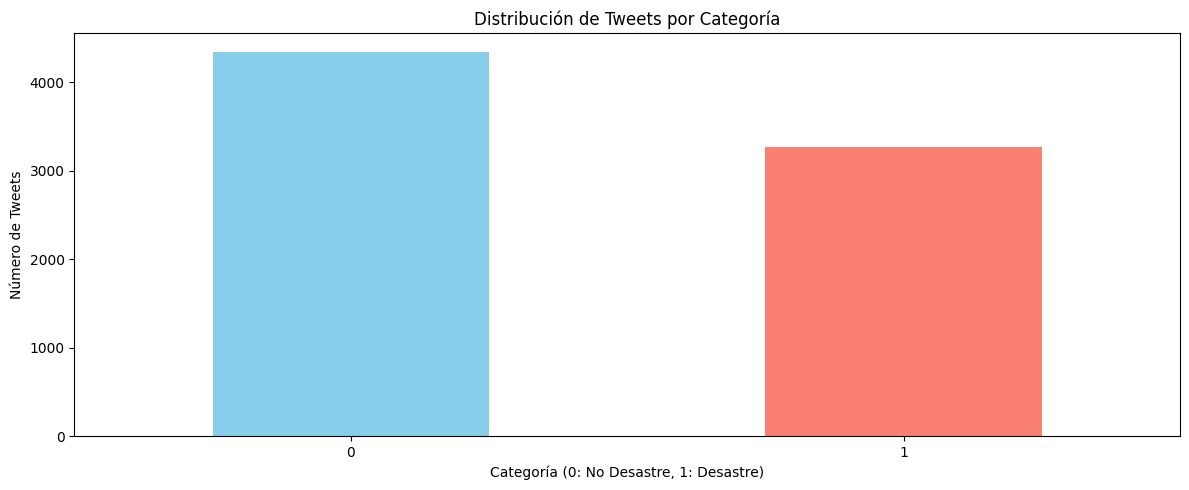

In [5]:
# Distribución de la variable objetivo
print("\n=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ===")
target_counts = df_train['target'].value_counts()
print(f"Tweets NO desastre (0): {target_counts[0]} ({target_counts[0]/len(df_train)*100:.1f}%)")
print(f"Tweets de desastre (1): {target_counts[1]} ({target_counts[1]/len(df_train)*100:.1f}%)")

# Visualización de la distribución
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

# Gráfico de barras
target_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Distribución de Tweets por Categoría')
ax1.set_xlabel('Categoría (0: No Desastre, 1: Desastre)')
ax1.set_ylabel('Número de Tweets')
ax1.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [6]:
# Ejemplos de tweets por categoría
print("\n=== EJEMPLOS DE TWEETS ===")
print("Tweets de DESASTRE:")
for i, tweet in enumerate(df_train[df_train['target']==1]['text'].head(3)):
    print(f"{i+1}. {tweet}")

print("\nTweets NO de desastre:")
for i, tweet in enumerate(df_train[df_train['target']==0]['text'].head(3)):
    print(f"{i+1}. {tweet}")


=== EJEMPLOS DE TWEETS ===
Tweets de DESASTRE:
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
2. Forest fire near La Ronge Sask. Canada
3. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

Tweets NO de desastre:
1. What's up man?
2. I love fruits
3. Summer is lovely


In [7]:
df_train["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

### Cleaning
Se descargan las stopword del paquete de nltk y se crea el tokenizador de tweets de la libreria nltk.

In [8]:
nltk.download("stopwords"); nltk.download("wordnet"); nltk.download("omw-1.4")
tt = TweetTokenizer(preserve_case=not True, reduce_len=True, strip_handles=False)
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gerax\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gerax\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Gerax\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Como el idioma del set es ingles se obtienen los stopwords en este idio y nos aseguramos que las palabras negativas que se queden porque estas son valiosas para el analiss

In [9]:
stopwords = set(nltk_stop.words("english"))
negs = {"no","not","n't"}
stopwords = {w for w in stopwords if w.lower() not in negs}

Se crean expresiones regualres especificas para cada parte de la limpieza que se quiere quitar.

In [10]:
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
APOSTROPHES_RE = re.compile(r"[’`´]")
EMOJI_RE = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE
)
NUMBER_RE = re.compile(r"\b\d+(?:[.,]\d+)*\b")

PUNCT_TABLE = str.maketrans("", "", string.punctuation)

In [11]:
def count_pattern(pat, text):
    return len(pat.findall(text))

Se crea una funcion donde se mapean todas las palabras y se quita lo siguiente:
- Se convirtio todo a minusculas.
- Se quitar los caracteres especiales que aparecen como *#*, *@* o los *apostrofes*
- Se quitar las url
- Se decidio quitar los emojis pero se quedo con una flag por si se quieren dejar.
- Se quitaron los signos de puntuación.
- Se quitaron las stopwords
- Se quitaron los numeros menos el 911

In [ ]:
def clean_raw(text: str) -> dict:
    original = text

    # Texto a minusculas
    text = text.lower()

    urls = mentions = emojis = hashtags = numbers = 0

    urls = count_pattern(URL_RE, text)
    text = URL_RE.sub(" ", text)

    mentions = count_pattern(MENTION_RE, text)
    text = MENTION_RE.sub(" ", text)

    hashtags = count_pattern(HASHTAG_RE, text)
    text = HASHTAG_RE.sub(lambda m: m.group(1), text)

    text = APOSTROPHES_RE.sub("'", text)

    if True: # Cambiar esto para cambiarlos emojis (si queres rayo)
        emojis = len(EMOJI_RE.findall(text))
        text = EMOJI_RE.sub(" ", text)

    # Aqui estan los numeros solo vamos a dejar el 911
    def num_filter(m):
        tok = m.group(0)
        return tok if tok in {"911"} else " "
    numbers = len(NUMBER_RE.findall(text))
    text = NUMBER_RE.sub(num_filter, text)

    text = text.translate(PUNCT_TABLE)

    text = re.sub(r"\s+", " ", text).strip()

    text = re.sub(r"[\x00-\x1f\x7f-\x9f\xad\x89]", " ", text) # AGREGA ESTO RAYO

    return {
        "text_raw": original,
        "text_clean_raw": text,
        "urls_removed": urls,
        "mentions_removed": mentions,
        "emojis_removed": emojis,
        "hashtags_unhashed": hashtags,
        "numbers_affected": numbers
    }

clean_rows = df_train["text"].map(clean_raw)
clean_df = pd.DataFrame(list(clean_rows))
df_train = pd.concat([df_train, clean_df], axis=1)

Por ultimo una vez limpiado los tweets lo que se realizo fue la tokenizacion de palabras de cada frase

In [ ]:
def tokenize_and_normalize(text: str):
    tokens = []
    toks = tt.tokenize(text)
    toks = [t for t in toks if all(ch not in string.punctuation for ch in t)]
    toks = [wnl.lemmatize(t) for t in toks]
    # stopwords
    toks = [t for t in toks if t.lower() not in stopwords]
    tokens = toks

    tokens = [t.strip() for t in tokens if t.strip() != ""]
    return tokens

df_train["tokens"] = df_train["text_clean_raw"].map(tokenize_and_normalize)
df_train["text_clean"] = df_train["tokens"].map(lambda ts: " ".join(ts))

In [ ]:
df_train["len_raw"] = df_train["text"].str.split().map(len)
df_train["len_clean"] = df_train["tokens"].map(len)

In [ ]:
# print(df[["id","target","text"]].head(3))
print(df_train[["text_clean_raw","tokens","text_clean"]].head(1))
# print(df[["urls_removed","mentions_removed","emojis_removed","hashtags_unhashed","numbers_affected"]].describe())
# print(df[["len_raw","len_clean"]].describe())

                                      text_clean_raw  \
0  our deeds are the reason of this earthquake ma...   

                                              tokens  \
0  [deed, reason, earthquake, may, allah, forgive...   

                                   text_clean  
0  deed reason earthquake may allah forgive u  
